**Solving tasks using one Conv2d(in_channels=10, out_channels=10, kernel_size=5, padding=2)

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

# Data Loading

In [2]:
import json
import os
from os.path import join as path_join


def load_data(path):
    tasks = pd.Series()
    for file_path in os.listdir(path):
        task_file = path_join(path, file_path)

        with open(task_file, 'r') as f:
            task = json.load(f)

        tasks[file_path[:-5]] = task
    return tasks

In [3]:
train_tasks = load_data('../abstraction-and-reasoning-challenge/training/')
evaluation_tasks = load_data('../abstraction-and-reasoning-challenge/evaluation/')
test_tasks = load_data('../abstraction-and-reasoning-challenge/test/')

train_tasks.head()

ea786f4a    {'train': [{'input': [[1, 1, 1], [1, 0, 1], [1...
eb281b96    {'train': [{'input': [[0, 0, 8, 0, 0, 0, 8, 0,...
eb5a1d5d    {'train': [{'input': [[8, 8, 8, 8, 8, 8, 8, 8,...
ec883f72    {'train': [{'input': [[3, 3, 0, 9, 0, 0], [3, ...
ecdecbb3    {'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0,...
dtype: object

# Model

In [4]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.nn import Conv2d
from torch import FloatTensor, LongTensor



def inp2img(inp):
    inp = np.array(inp)
    img = np.full((10, inp.shape[0], inp.shape[1]), 0, dtype=np.uint8)
    for i in range(10):
        img[i] = (inp==i)
    return img


class TaskSolver:        
    def train(self, task_train, n_epoch=30):
        """basic pytorch train loop"""
        self.net = Conv2d(in_channels=10, out_channels=10, kernel_size=5, padding=2)
        
        criterion = CrossEntropyLoss()
        optimizer = Adam(self.net.parameters(), lr = 0.1)
        
        for epoch in range(n_epoch):
            for sample in task_train:
                inputs = FloatTensor(inp2img(sample['input'])).unsqueeze(dim=0)
                labels = LongTensor(sample['output']).unsqueeze(dim=0)
                
                optimizer.zero_grad()
                outputs = self.net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
        return self
            
    def predict(self, task_test):
        predictions = []
        with torch.no_grad():
            for sample in task_test:
                inputs = FloatTensor(inp2img(sample['input'])).unsqueeze(dim=0)
                outputs = self.net(inputs)
                pred =  outputs.squeeze(dim=0).cpu().numpy().argmax(0)
                predictions.append(pred)
                                     
        return predictions

# Results

In [5]:
def input_output_shape_is_same(task):
    return all([np.array(el['input']).shape == np.array(el['output']).shape for el in task['train']])

def calk_score(task_test, predict):
    return [int(np.equal(sample['output'], pred).all()) for sample, pred in zip(task_test, predict)]

In [6]:
def evaluate(tasks):
    ts = TaskSolver()
    result = []
    predictions = []
    for task in tqdm(tasks):
        if input_output_shape_is_same(task):
            ts.train(task['train'])
            pred = ts.predict(task['test'])
            score = calk_score(task['test'], pred)
        else:
            pred = [el['input'] for el in task['test']]
            score = [0]*len(task['test'])
        
        predictions.append(pred)
        result.append(score)
       
    return result, predictions

In [7]:
train_result, train_predictions = evaluate(train_tasks)
train_solved = [any(score) for score in train_result]

total = sum([len(score) for score in train_result])
print(f"solved : {sum(train_solved)} from {total} ({sum(train_solved)/total})")

100%|██████████| 400/400 [00:15<00:00, 25.30it/s]

solved : 11 from 416 (0.026442307692307692)


In [8]:
evaluation_result, evaluation_predictions = evaluate(evaluation_tasks)
evaluation_solved = [any(score) for score in evaluation_result]

total = sum([len(score) for score in evaluation_result])
print(f"solved : {sum(evaluation_solved)} from {total} ({sum(evaluation_solved)/total})")

100%|██████████| 400/400 [00:19<00:00, 20.80it/s]

solved : 4 from 419 (0.00954653937947494)


# Visualize

visualize solved tasks

In [9]:
import matplotlib.pyplot as plt
from matplotlib import colors


cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
    
def plot_pictures(pictures, labels):
    fig, axs = plt.subplots(1, len(pictures), figsize=(2*len(pictures),32))
    for i, (pict, label) in enumerate(zip(pictures, labels)):
        axs[i].imshow(np.array(pict), cmap=cmap, norm=norm)
        axs[i].set_title(label)
    plt.show()
    

def plot_sample(sample, predict=None):
    if predict is None:
        plot_pictures([sample['input'], sample['output']], ['Input', 'Output'])
    else:
        plot_pictures([sample['input'], sample['output'], predict], ['Input', 'Output', 'Predict'])

### train solved tasks

0it [00:00, ?it/s]

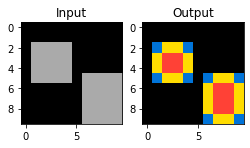

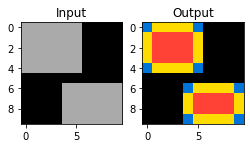

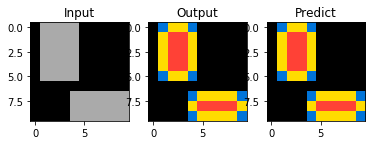

82it [00:00, 102.99it/s]

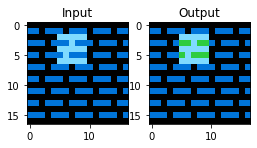

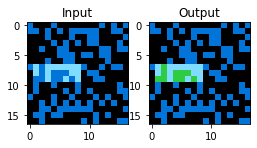

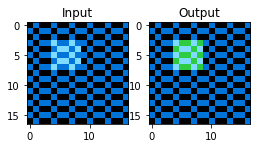

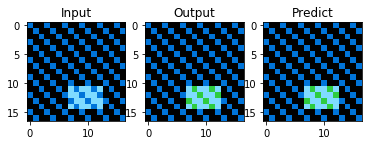

223it [00:01, 118.77it/s]

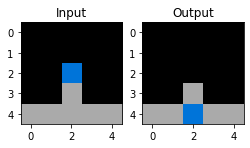

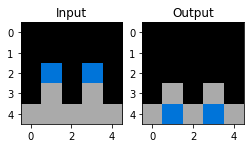

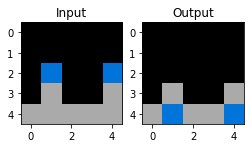

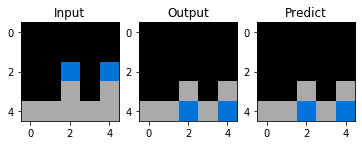

231it [00:02, 27.37it/s] 

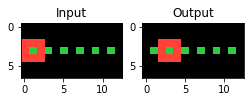

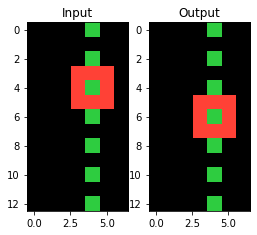

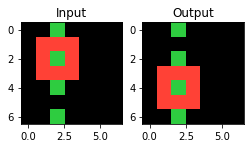

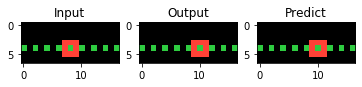

275it [00:03, 32.62it/s]

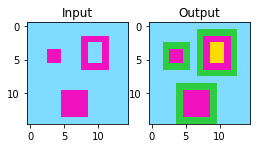

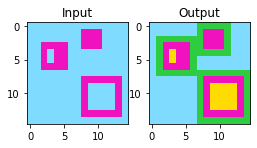

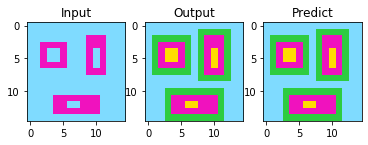

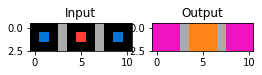

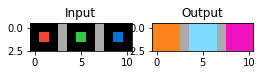

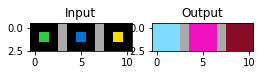

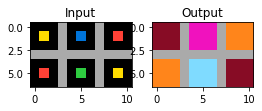

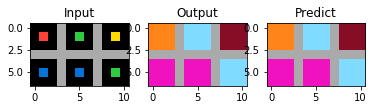

281it [00:04, 10.13it/s]

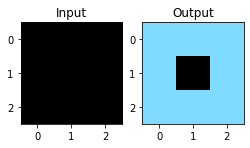

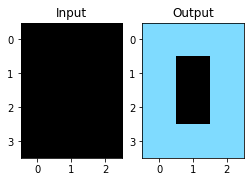

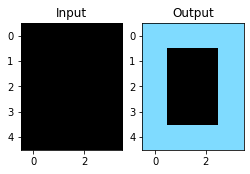

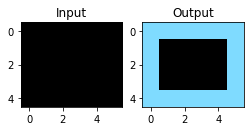

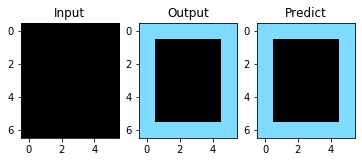

326it [00:05, 13.31it/s]

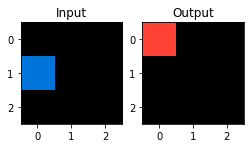

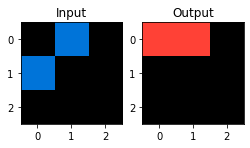

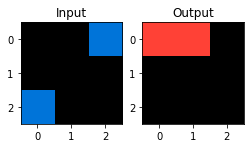

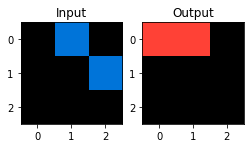

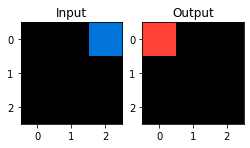

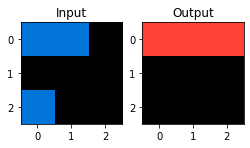

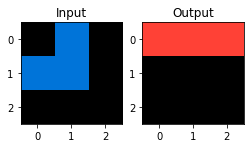

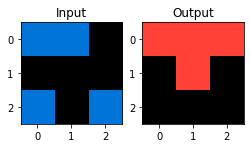

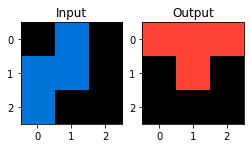

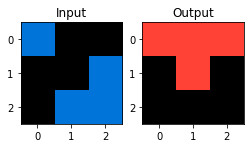

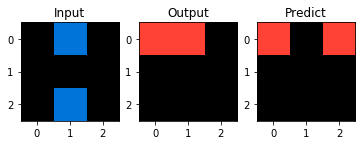

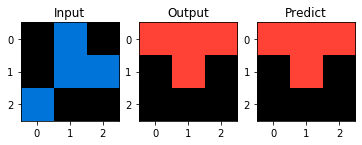

341it [00:07, 10.43it/s]

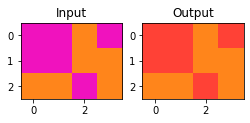

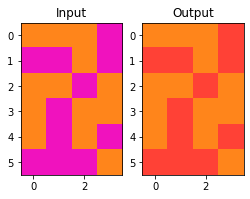

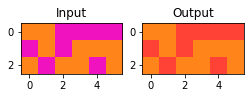

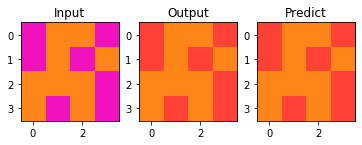

359it [00:08, 12.59it/s]

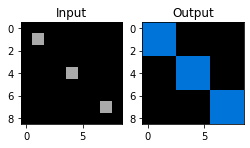

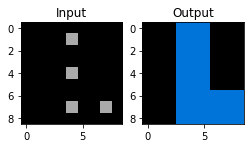

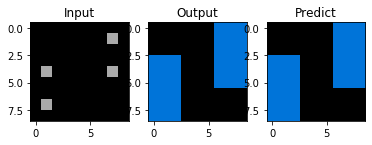

373it [00:09, 14.65it/s]

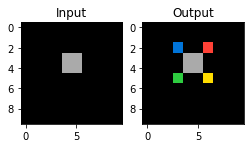

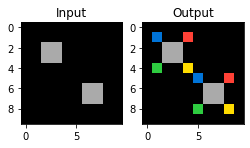

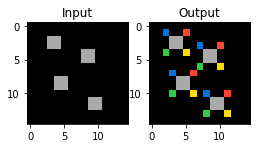

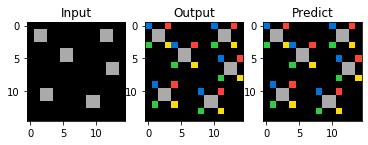

400it [00:09, 40.53it/s]


In [10]:
for task, prediction, solved in tqdm(zip(train_tasks, train_predictions, train_solved)):
    if solved:
        for i in range(len(task['train'])):
            plot_sample(task['train'][i])
            
        for i in range(len(task['test'])):
            plot_sample(task['test'][i], prediction[i])

### evaluation solved tasks

0it [00:00, ?it/s]

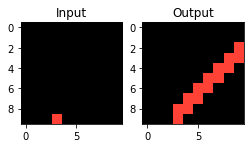

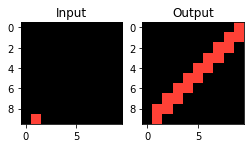

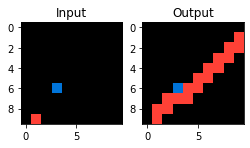

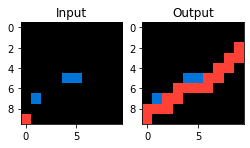

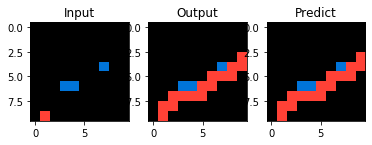

34it [00:00, 37.97it/s]

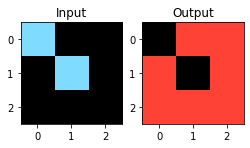

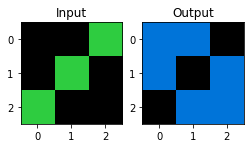

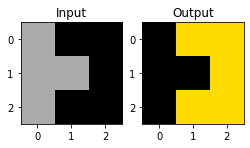

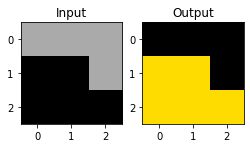

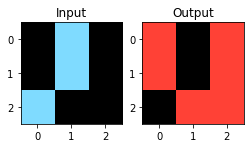

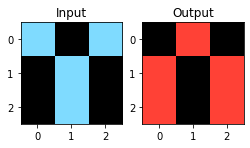

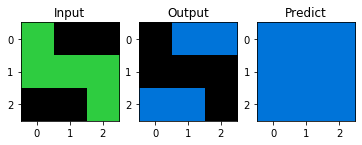

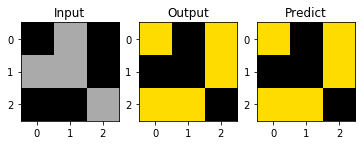

38it [00:02,  7.45it/s]

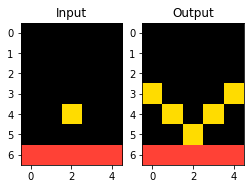

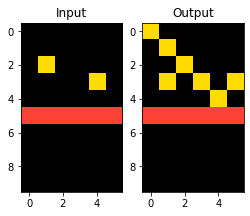

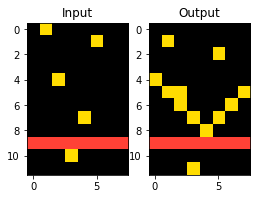

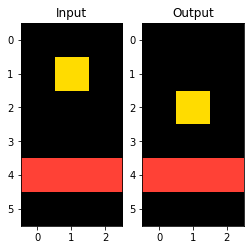

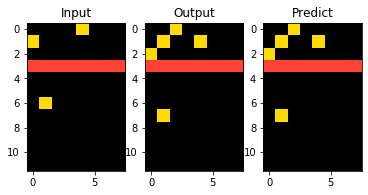

46it [00:03,  7.70it/s]

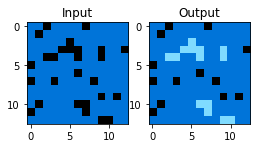

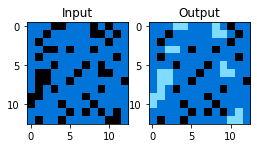

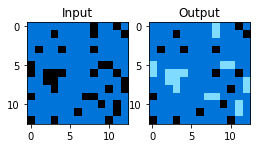

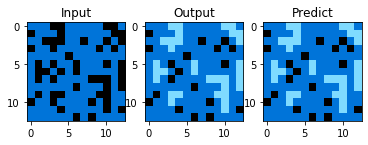

400it [00:04, 95.37it/s]


In [11]:
for task, prediction, solved in tqdm(zip(evaluation_tasks, evaluation_predictions, evaluation_solved)):
    if solved:
        for i in range(len(task['train'])):
            plot_sample(task['train'][i])
            
        for i in range(len(task['test'])):
            plot_sample(task['test'][i], prediction[i])

# Prediction

In [12]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

def make_pediction(tasks):
    ts = TaskSolver()
    result = pd.Series()
    for idx, task in tqdm(test_tasks.iteritems()):
        if input_output_shape_is_same(task):
            ts.train(task['train'])
            pred = ts.predict(task['test'])
        else:
            pred = [el['input'] for el in task['test']]
        
        for i, p in enumerate(pred):
            result[f'{idx}_{i}'] = flattener(np.array(p).tolist())
       
    return result

In [13]:
submission = make_pediction(test_tasks)
submission.head()

100it [00:04, 21.11it/s]


0d87d2a6_0    |0000010002210000000000000|0000000001110000000...
18419cfa_0    |00000000000000000000000000|000000000000000000...
281123b4_0    |8880350553900030000|8088355553009934404|80083...
292dd178_0    |999222922222229|912212221111225|2122122212222...
29700607_0    |00084400000|00000000000|00000003000|000000000...
dtype: object

In [14]:
submission = submission.reset_index()
submission.columns = ['output_id', 'output']
submission.to_csv('submission.csv', index=False)
submission

,output_id,output
0,0d87d2a6_0,|0000010002210000000000000|0000000001110000000...
1,18419cfa_0,|00000000000000000000000000|000000000000000000...
2,281123b4_0,|8880350553900030000|8088355553009934404|80083...
3,292dd178_0,|999222922222229|912212221111225|2122122212222...
4,29700607_0,|00084400000|00000000000|00000003000|000000000...
...,...,...
99,0b17323b_0,|100000000000000|000000000000000|0000000000000...
100,0bb8deee_0,|0000001000000|0000001000000|0000001003330|002...
101,0becf7df_0,|4000000000|2000000000|0000020000|0000220000|0...
102,0c786b71_0,|8578|7788|5585|


# All train tasks predictions

0it [00:00, ?it/s]

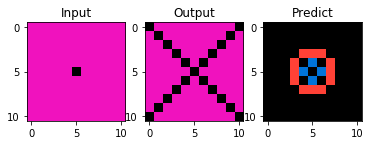

1it [00:00,  4.01it/s]

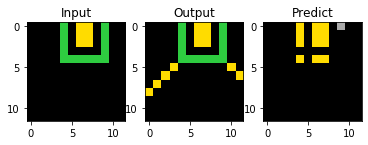

4it [00:00,  5.03it/s]

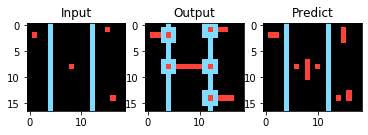

5it [00:00,  4.70it/s]

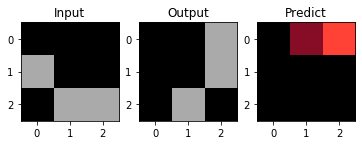

6it [00:00,  4.50it/s]

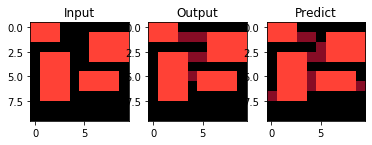

7it [00:01,  4.34it/s]

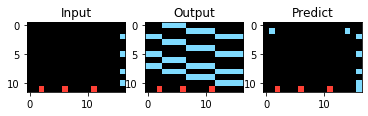

8it [00:01,  4.31it/s]

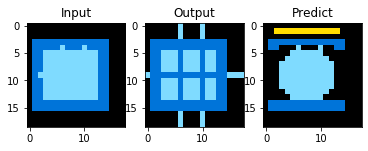

9it [00:01,  4.23it/s]

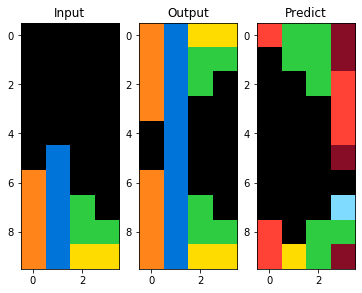

11it [00:01,  4.91it/s]

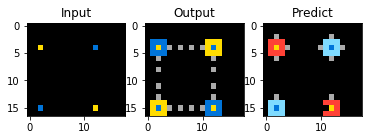

13it [00:02,  5.30it/s]

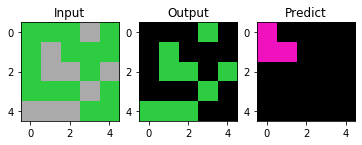

15it [00:02,  5.93it/s]

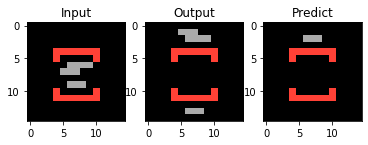

16it [00:02,  5.18it/s]

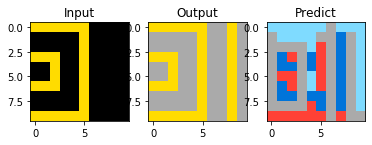

18it [00:03,  5.84it/s]

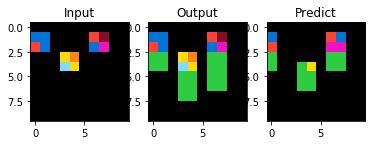

23it [00:03,  7.44it/s]

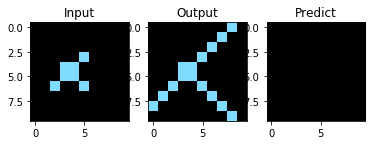

29it [00:03,  9.43it/s]

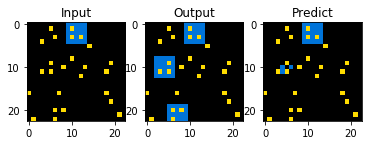

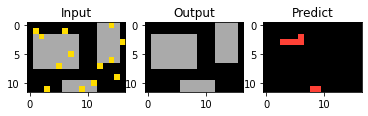

31it [00:03,  6.90it/s]

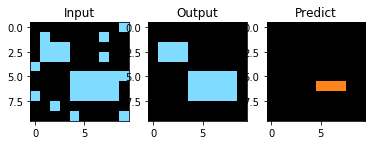

33it [00:04,  7.25it/s]

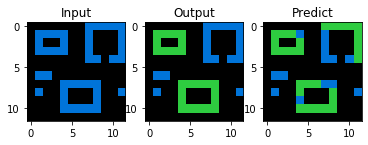

35it [00:04,  7.04it/s]

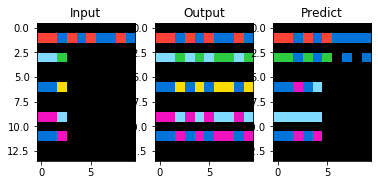

36it [00:04,  5.65it/s]

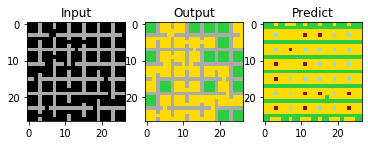

37it [00:05,  5.08it/s]

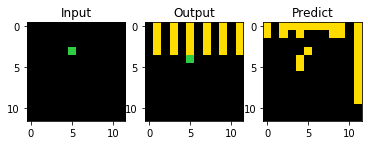

38it [00:05,  4.75it/s]

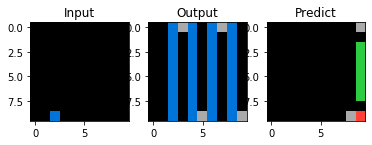

39it [00:05,  4.56it/s]

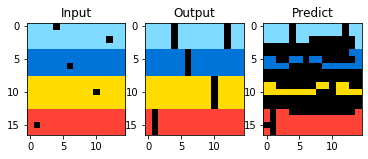

41it [00:05,  5.24it/s]

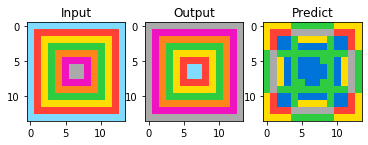

42it [00:05,  4.83it/s]

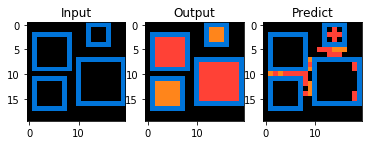

43it [00:06,  4.57it/s]

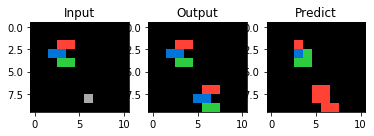

45it [00:06,  5.26it/s]

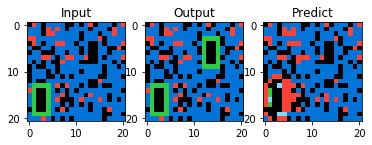

47it [00:06,  5.56it/s]

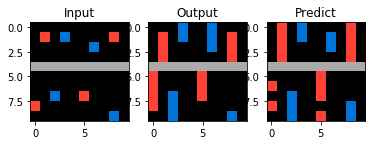

51it [00:07,  6.94it/s]

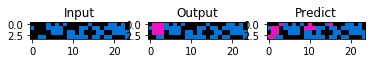

52it [00:07,  5.81it/s]

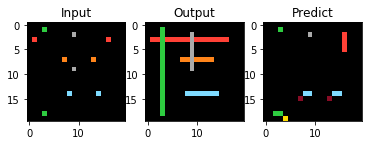

54it [00:07,  6.37it/s]

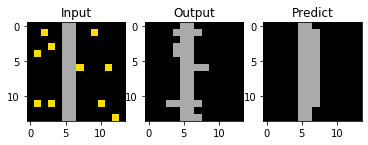

55it [00:07,  5.46it/s]

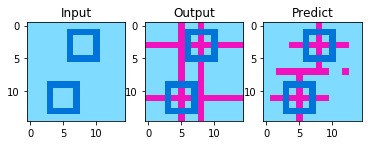

56it [00:08,  4.95it/s]

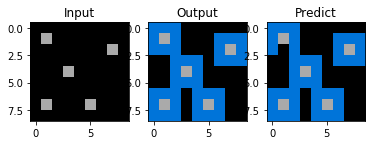

57it [00:08,  4.64it/s]

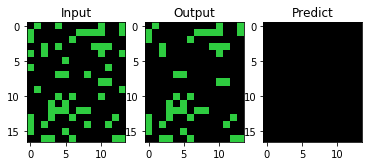

59it [00:08,  5.31it/s]

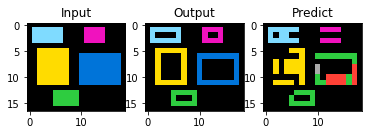

60it [00:08,  4.85it/s]

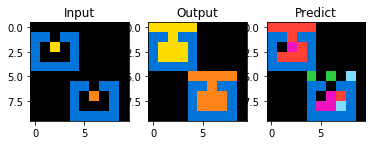

61it [00:09,  4.27it/s]

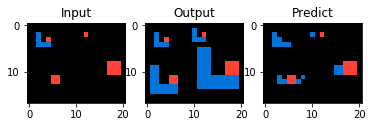

63it [00:09,  4.99it/s]

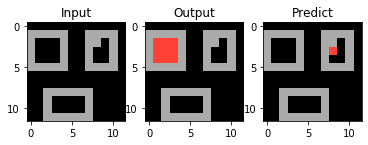

64it [00:09,  4.68it/s]

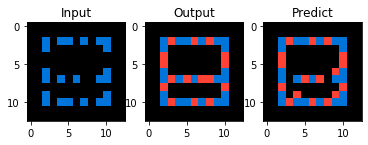

67it [00:09,  5.74it/s]

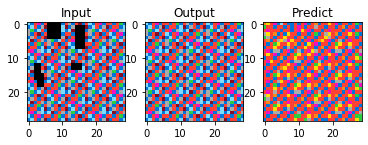

72it [00:10,  7.32it/s]

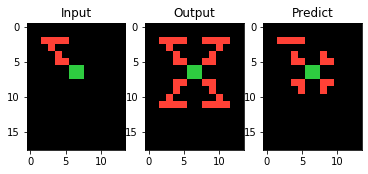

74it [00:10,  7.47it/s]

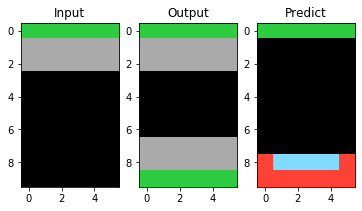

76it [00:10,  7.62it/s]

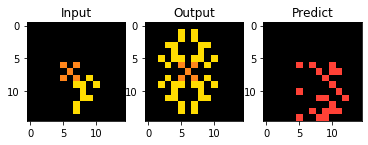

79it [00:10,  8.59it/s]

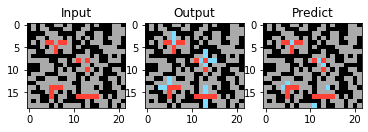

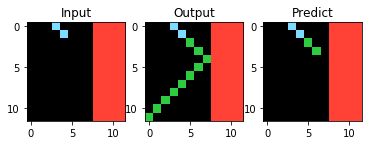

81it [00:11,  6.11it/s]

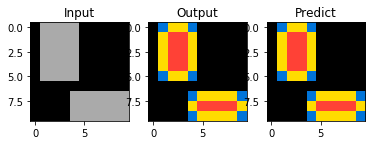

82it [00:11,  5.36it/s]

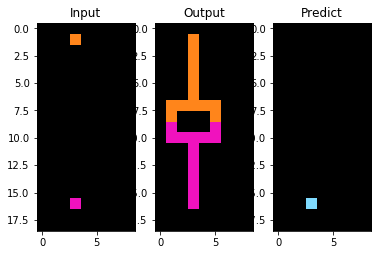

83it [00:11,  4.76it/s]

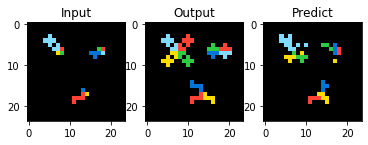

84it [00:12,  4.56it/s]

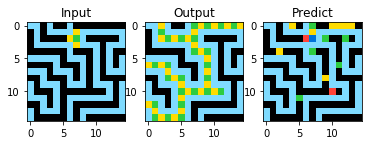

85it [00:12,  4.38it/s]

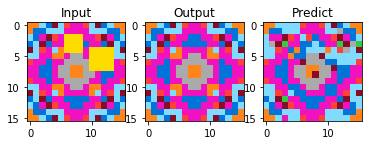

86it [00:12,  4.28it/s]

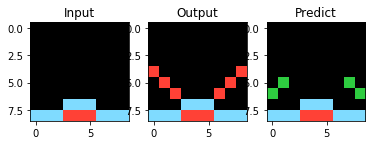

87it [00:12,  4.22it/s]

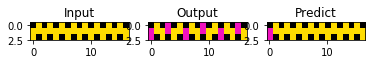

91it [00:13,  5.47it/s]

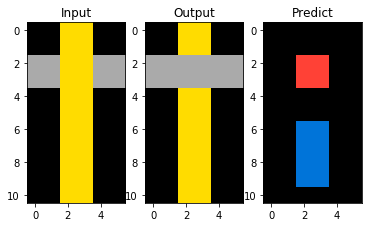

92it [00:13,  4.87it/s]

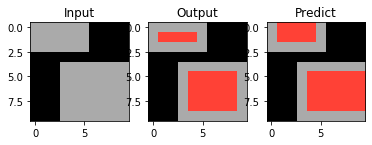

93it [00:13,  4.30it/s]

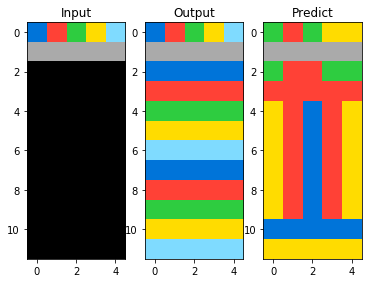

96it [00:13,  5.29it/s]

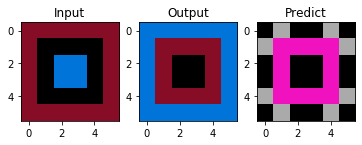

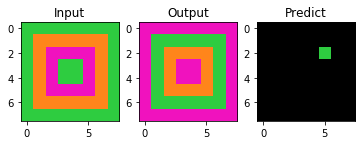

97it [00:14,  3.59it/s]

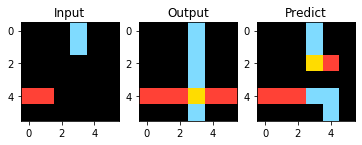

98it [00:14,  3.72it/s]

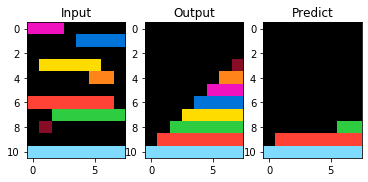

100it [00:14,  4.43it/s]

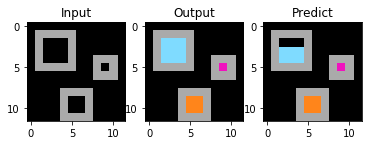

101it [00:15,  4.33it/s]

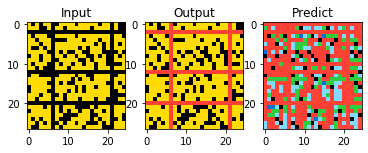

102it [00:15,  4.25it/s]

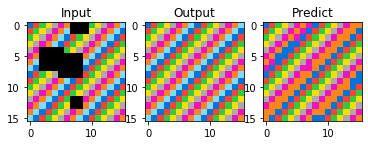

104it [00:15,  4.96it/s]

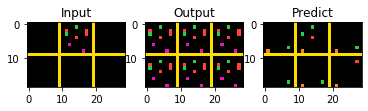

105it [00:15,  4.31it/s]

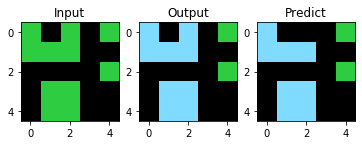

107it [00:16,  5.00it/s]

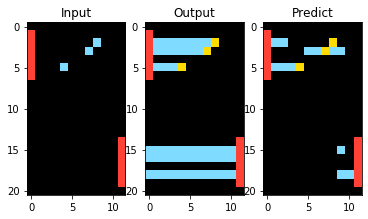

108it [00:16,  4.46it/s]

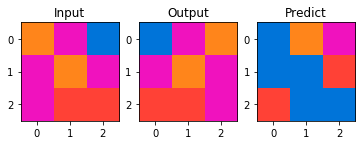

110it [00:16,  5.12it/s]

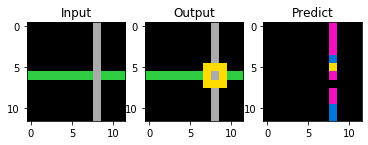

111it [00:16,  4.68it/s]

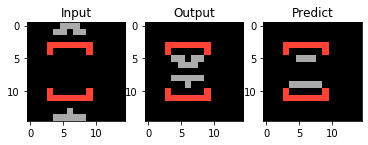

114it [00:17,  5.67it/s]

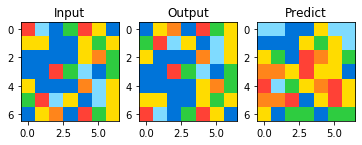

115it [00:17,  4.82it/s]

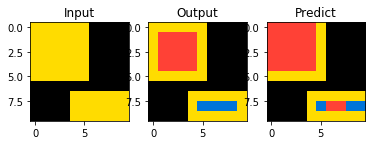

116it [00:17,  4.50it/s]

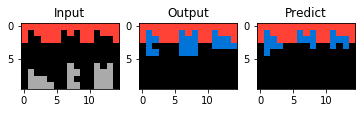

117it [00:17,  4.25it/s]

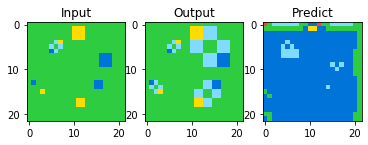

118it [00:18,  3.73it/s]

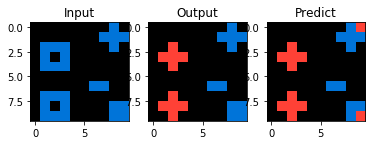

120it [00:18,  4.47it/s]

In [ ]:
for task, prediction in tqdm(zip(train_tasks, train_predictions)):
    if input_output_shape_is_same(task):
        for i in range(len(task['test'])):
            plot_sample(task['test'][i], prediction[i])